# FIT5202 - Data processing for Big Data

## Assignment 2: Detecting Linux system hacking activities Part B

Name: Roma Hambar\
Student ID: 31223958\
Python Version Used: Python 3

<h1>Streaming Data Modelling </h1>

* [Task 1: Initialize Spark Session](#Initialize)
* [Task 2: Injest Streaming data](#Injest)
* [Task 3: Data Transformation according to metadata rules](#metadata)
    * [Process Data Transformation](#process)
    * [Memory Data Transformation](#memory)
    * [Data Wrangling](#wrangling)
        * [Numeric column transformation](#numeric)
        * [NICE and PRI column transformation](#rules)
* [Task 4: Create join key and record event time](#cmd_pid)
* [Task 5: Persist the dataframes to Parquet File](#parquet)
* [Task 6: Load Prediction Model](#model)
* [Task 7: Find potential attacks in process and memory activities](#attacks)
    * [a. Monitor attacks within a 2-minute window](#window)
    * [b. Find attacks common in both process and memory](#join)
* [Task 8: Visualize suspect process and memory attacks](#suspect)


## 1. Initialize Spark Session <a class="anchor" name="Initialize"></a>

The following SparkSession configuartion has been used for this task:
 - two local cores with a proper application name
 - timezone set to UTC
 
Using os package, add kafka streaming libraries in the pyspark execution path.

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,\
org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

In [2]:
# Import Packages required 

from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import datetime as dt
from pyspark.sql.types import TimestampType
from time import sleep

from pyspark.ml import PipelineModel
import matplotlib.pyplot as plt

# Import SparkConf, SparkSession and SparkContext classes for Spark Session setup and Spark SQL 
# operations for further analysis
from pyspark import SparkConf
from pyspark.sql import SparkSession # Spark SQL
from pyspark import SparkContext #Spark

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

In [3]:
# Run Spark in local mode with 2 working processors as logical cores on your machine
master = "local[2]"

# Set the name for Spark application
app_name = "Streaming application"

# Setup configuration parameters for Spark Session and set UTC timezone
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set('spark.sql.session.timeZone', 'UTC')

# Initialize Spark Session and create a SparkContext Object
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

## 2. Injest Streaming data <a class="anchor" name="Injest"></a>

Ingest the streaming data into Spark Streaming for both process and memory activities using Kafka topics used in the previous task. The streaming data in the topics is stored in `binary` format in key-value format. To make them in human readable format, we will `Cast` the key-value pair records to String format using the dataframe function `selectExpr`

- For Process Activities Data 

In [4]:
process_topic = 'process'

In [5]:
# Subscribe to kafka process topic and load the streaming data into a dataframe
process_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", process_topic) \
    .load()

In [6]:
# Convert Binary data records to String key value records
process_df = process_df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [7]:
# Print Dataframe format
process_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: string (nullable = true)



- For Memory Activities Data

In [8]:
memory_topic = 'memory'

In [9]:
# Subscribe to kafka memory topic and load the streaming data into a dataframe
memory_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", memory_topic) \
    .load()

In [10]:
# Convert Binary data records to String key value records
memory_df = memory_df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [11]:
# Print Dataframe format
memory_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: string (nullable = true)



## 3. Data Transformation according to metadata rules <a class="anchor" name="metadata"></a>

After the above key-value string transformation, we see that the records are in `JSON` format stored in the value part of the data record. To read them in correct dataformat, we will reset all the column datatypes using metadata information provided to us.  

- Using the metadata information about both the process activities data and memory activities data, we will modify the string data to required data format. 

    The topic data has been stored in the following format:
        [
        [{sequence:1, machine:4,..},{sequence:2, machine:4,..},..],
        [{sequence:1, machine:5,..},{sequence:2, machine:5,..},..],
        [{sequence:1, machine:6,..},{sequence:2, machine:6,..},..],
        [{sequence:1, machine:7,..},{sequence:2, machine:7,..},..],
        [{sequence:1, machine:8,..},{sequence:2, machine:8,..},..]
        ]

    i.e array of array of data records for each machine.
- Extract the data records stored in nested JSON format using python sql function `explode` function
- Modify the datatype and column names according to the metadata file

### A. Process Data Transformation <a class="anchor" name="process"></a>

In [12]:
# Set Custom Schema for process dataframe
process_customSchema = ArrayType(ArrayType(StructType([   
    StructField("sequence", IntegerType(), True),
    StructField("machine", IntegerType(), True),        
    StructField("PID", IntegerType(), True),
    StructField("TRUN", IntegerType(), True),
    StructField("TSLPI", IntegerType(), True),
    StructField("TSLPU", IntegerType(), True),
    StructField("POLI", StringType(), True),
    StructField("NICE", IntegerType(), True),
    StructField("PRI", IntegerType(), True),
    StructField("RTPR", IntegerType(), True),
    StructField("CPUNR", IntegerType(), True),
    StructField("Status", StringType(), True),
    StructField("EXC", IntegerType(), True),
    StructField("State", StringType(), True),
    StructField("CPU", DoubleType(), True),
    StructField("CMD", StringType(), True),
    StructField("ts", StringType(), True)
])))

In [13]:
# Restructure the process dataframe by removing the key from the records 
# and parse the JSON value using custom schema designed
# Rename the new parsed data column
process_df = process_df.select(F.from_json(F.col("value").cast("string"), process_customSchema).alias('parsed_value'))

In [14]:
# Explode the parsed values to unnested values to read the list values
process_df = process_df.select(F.explode(F.col("parsed_value")).alias('unnested_value'))    

In [15]:
# Explode the unnested values again to unnested values to read individual records from the list
process_df = process_df.select(F.explode(F.col("unnested_value")).alias('unnested_value'))

In [16]:
# Select the columns from the process dataframe and modify datatype and column name
process_df = process_df.select(
                    F.col("unnested_value.sequence").alias("sequence"),
                    F.col("unnested_value.machine").alias("machine"),
                    F.col("unnested_value.PID").alias("PID"),
                    F.col("unnested_value.TRUN").alias("TRUN"),
                    F.col("unnested_value.TSLPI").alias("TSLPI"),
                    F.col("unnested_value.TSLPU").alias("TSLPU"),
                    F.col("unnested_value.POLI").alias("POLI"),
                    F.col("unnested_value.NICE").alias("NICE"),
                    F.col("unnested_value.PRI").alias("PRI"),
                    F.col("unnested_value.RTPR").alias("RTPR"),
                    F.col("unnested_value.CPUNR").alias("CPUNR"),
                    F.col("unnested_value.Status").alias("Status"),
                    F.col("unnested_value.EXC").alias("EXC"),
                    F.col("unnested_value.State").alias("State"),
                    F.col("unnested_value.CPU").alias("CPU"),
                    F.col("unnested_value.CMD").alias("CMD"),
                    F.col("unnested_value.ts").alias("ts")
                )

In [17]:
# Print Schema to observe how the JSON data structure has been structured
process_df.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: string (nullable = true)



### B. Memory Data Transformation  <a class="anchor" name="memory"></a>

In [18]:
# Set Custom Schema for memory dataframe
memory_customSchema = ArrayType(ArrayType(StructType([   
    StructField("sequence", IntegerType(), True),
    StructField("machine", IntegerType(), True),        
    StructField("PID", IntegerType(), True),
    StructField("MINFLT", IntegerType(), True),
    StructField("MAJFLT", IntegerType(), True),
    StructField("VSTEXT", IntegerType(), True),
    StructField("VSIZE", DoubleType(), True),
    StructField("RSIZE", DoubleType(), True),
    StructField("VGROW", DoubleType(), True),
    StructField("RGROW", DoubleType(), True),
    StructField("MEM", DoubleType(), True),
    StructField("CMD", StringType(), True),
    StructField("ts", StringType(), True)
])))

In [19]:
# Restructure the process dataframe by removing the key from the records 
# and parse the JSON value using custom schema designed
# Rename the new parsed data column
memory_df = memory_df.select(F.from_json(F.col("value").cast("string"), memory_customSchema).alias('parsed_value'))

In [20]:
# Explode the parsed values to unnested values to read the list values
memory_df = memory_df.select(F.explode(F.col("parsed_value")).alias('unnested_value'))    

In [21]:
# Explode the unnested values again to unnested values to read individual records from the list
memory_df = memory_df.select(F.explode(F.col("unnested_value")).alias('unnested_value'))

In [22]:
# Select the columns from the memory dataframe and modify datatype and column name
memory_df = memory_df.select(
                    F.col("unnested_value.sequence").alias("sequence"),
                    F.col("unnested_value.machine").alias("machine"),
                    F.col("unnested_value.PID").alias("PID"),
                    F.col("unnested_value.MINFLT").alias("MINFLT"),
                    F.col("unnested_value.MAJFLT").alias("MAJFLT"),
                    F.col("unnested_value.VSTEXT").alias("VSTEXT"),
                    F.col("unnested_value.VSIZE").alias("VSIZE"),
                    F.col("unnested_value.RSIZE").alias("RSIZE"),
                    F.col("unnested_value.VGROW").alias("VGROW"),
                    F.col("unnested_value.RGROW").alias("RGROW"),
                    F.col("unnested_value.MEM").alias("MEM"),
                    F.col("unnested_value.CMD").alias("CMD"),
                    F.col("unnested_value.ts").alias("ts")
                )

In [23]:
# Print Schema to observe how the JSON data structure has been structured
memory_df.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: integer (nullable = true)
 |-- VSTEXT: integer (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: string (nullable = true)



### C. Data Wrangling <a class="anchor" name="wrangling"></a>

### i) Numeric column transformation <a class="anchor" name="numeric"></a>

In [24]:
# Replace symbolic representation of K with 3 zeroes
memory_df = memory_df.withColumn('MINFLT', regexp_replace('MINFLT', 'K', '000'))\
.withColumn('MAJFLT', regexp_replace('MAJFLT', 'K', '000'))\
.withColumn('VSTEXT', regexp_replace('VSTEXT', 'K', '000'))\
.withColumn('RSIZE', regexp_replace('RSIZE', 'K', '000'))\
.withColumn('VGROW', regexp_replace('VGROW', 'K', '000'))\
.withColumn('RGROW', regexp_replace('RGROW', 'K', '000'))

In [25]:
# Replace symbolic representation of M with 5 zeroes to replace with exact decimal value
memory_df = memory_df.withColumn('MAJFLT', regexp_replace('MAJFLT', '.2M', '200000'))\
.withColumn('MAJFLT', regexp_replace('MAJFLT', '.4M', '400000'))\
.withColumn('RSIZE', regexp_replace('RSIZE', '.2M', '200000'))\
.withColumn('RSIZE', regexp_replace('RSIZE', '.4M', '400000'))

In [26]:
# Replace symbolic representation of K with 3 zeroes
memory_df = memory_df.withColumn('MINFLT', regexp_replace('MINFLT', 'G', '000000000'))\
.withColumn('MAJFLT', regexp_replace('MAJFLT', 'G', '000000000'))\
.withColumn('VSTEXT', regexp_replace('VSTEXT', 'G', '000000000'))\
.withColumn('RSIZE', regexp_replace('RSIZE', 'G', '000000000'))\
.withColumn('VGROW', regexp_replace('VGROW', 'G', '000000000'))\
.withColumn('RGROW', regexp_replace('RGROW', 'G', '000000000'))

In [27]:
#Removing the space in between some values",
memory_df = memory_df.withColumn('VGROW', regexp_replace('VGROW', ' ', ''))\
.withColumn('RGROW', regexp_replace('RGROW', ' ', ''))

In [28]:
memory_df = memory_df.withColumn('MINFLT', memory_df['MINFLT'].cast(IntegerType()))\
.withColumn('MAJFLT', memory_df['MAJFLT'].cast(IntegerType()))\
.withColumn('VSTEXT', memory_df['VSTEXT'].cast(IntegerType()))\
.withColumn('RSIZE', memory_df['RSIZE'].cast(IntegerType()))\
.withColumn('VGROW', memory_df['VGROW'].cast(IntegerType()))\
.withColumn('RGROW', memory_df['RGROW'].cast(IntegerType()))

### ii) NICE and PRI column transformation <a class="anchor" name="rules"></a>

In [29]:
# Conditions on testing whether NICE and PRI follow the their functional criteria for each linux activity
nice_pri_correction = when(process_df.PRI == 100, 100-120)\
            .when(process_df.PRI == 109, 109-120)\
            .when(process_df.PRI == 121, 121-120)\
            .when(process_df.PRI == 130, 130-120)\
            .when(process_df.PRI == 139, 139-120)\
            .otherwise(0)

In [30]:
# Drop the previous unclean NICE column and append the new column as the new NICE column
process_df = process_df.drop('NICE').withColumn('NICE', nice_pri_correction)\
.select('sequence', 'machine', 'PID', 'TRUN', 'TSLPI', 'TSLPU', 'POLI', 'NICE','PRI', 'RTPR', 'CPUNR', 
        'Status', 'EXC', 'State', 'CPU', 'CMD', 'ts')

### 4. Create join key and record event time <a class="anchor" name="cmd_pid"></a>

Concatenate the CMD and PID columns to track the activities common in both process and memory activities streaming data. At the producer level, timestamp was recorded when the data was published to the kafka topic. This timestamp was stored in the String datatype. Duplicate the ts column to event_time as Timestamp datatype. This event_time column is created to allow 20-second tolerance for possible data delay on “event_time” using watermarking.

In [31]:
# Concatenate CMD and PID columns. concat() and lit() is used to join literal characters as sql function
process_df = process_df.withColumn('CMD_PID',F.concat(F.col('CMD'),F.lit('_'), F.col('PID')))

In [32]:
# Duplicate the ts column and and modify it to the Timestamp datatype
process_df = process_df.withColumn('event_time',F.from_unixtime('ts').cast(TimestampType()))
# Using withWatermark, set a time interval within which we will record late incoming data records
process_df = process_df.withWatermark('event_time', '20 seconds')

In [33]:
# Print Schema
process_df.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = false)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- CMD_PID: string (nullable = true)
 |-- event_time: timestamp (nullable = true)



In [34]:
# Concatenate CMD and PID columns. concat() and lit() is used to join literal characters as sql function
memory_df = memory_df.withColumn('CMD_PID', F.concat(F.col('CMD'),F.lit('_'), F.col('PID')))

In [35]:
# Duplicate the ts column and and modify it to the Timestamp datatype
memory_df = memory_df.withColumn('event_time',F.from_unixtime('ts').cast(TimestampType()))
# Using withWatermark, set a time interval within which we will record late incoming data records
memory_df = memory_df.withWatermark('event_time', '20 seconds')

In [36]:
# Print Schema
memory_df.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: integer (nullable = true)
 |-- VSTEXT: integer (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: integer (nullable = true)
 |-- VGROW: integer (nullable = true)
 |-- RGROW: integer (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- CMD_PID: string (nullable = true)
 |-- event_time: timestamp (nullable = true)



### 5. Persist the dataframes to Parquet File <a class="anchor" name="parquet"></a>

Write the realtime streaming process and memory activities data to parquet data file. The streaming data would be appended to the file. 


In [37]:
# Create process file sink to write the process data streaming to parquet file
process_query_file_sink = process_df.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "parquet/process")\
        .option("checkpointLocation", "parquet/process/checkpoint")\
        .start()

In [40]:
# process_query_file_sink.stop()

In [38]:
# Create process file sink to write the memory data streaming to parquet file
memory_query_file_sink = memory_df.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "parquet/memory")\
        .option("checkpointLocation", "parquet/memory/checkpoint")\
        .start()

In [41]:
# memory_query_file_sink.stop()

### 6. Load Prediction Model <a class="anchor" name="model"></a>

Using machine learning model to predict whether the system was under attack, we will load the machine leaning pipeline model and generate predictions on the process and memory activities to classify whether the system was under attack under the given activity information. We are interested in finding activities when the system is predicted to be under attack. 

In [39]:
# load the pipeline model for process and memory data
pipelineModel_process = PipelineModel.load('process_pipeline_model')
pipelineModel_memory = PipelineModel.load('memory_pipeline_model')

In [42]:
# generate predictions on whether system is under attack during process or memory activity
process_predictions = pipelineModel_process.transform(process_df)
memory_predictions = pipelineModel_memory.transform(memory_df)

In [43]:
# Filter activities when the system was under attack. Prediction is set to 1.0 when an attack is found.
process_attack_predictions = process_predictions.filter(col('prediction') == 1.0)
memory_attack_predictions = memory_predictions.filter(col('prediction') == 1.0)

In [44]:
# Write the process activities under attack records to console to monitor the data in realtime
# Activity predictions would be triggered after every 5 seconds 
# downstream data records are written to console in append mode
process_query = process_attack_predictions \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .start()

In [45]:
# Write the process activities under attack records to console to monitor the data in realtime
# Activity predictions would be triggered after every 5 seconds 
# downstream data reecords are written to console in append mode
memory_query = memory_attack_predictions \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .start()

In [46]:
process_query.stop()
memory_query.stop()

### 7. Find Potential attacks in process and memory activities <a class="anchor" name="attacks"></a>

### 7a. Monitor attacks within a 2-minute window <a class="anchor" name="monitor"></a>

- Process Activity monitoring

In [47]:
# For a window period of 2 mins i.e. 120 seconds (considering the 119 seconds to avoid duplicate counts), 
# finding the approximate distinct count of attacks in process activites
# window() function is used to sliding window on the timeline of size 120 seconds
# approx_count_distinct() will count distinct records in a window period
process_attack_machine = process_attack_predictions \
    .groupBy('machine', window(process_attack_predictions.event_time, "119 seconds"))\
    .agg(F.approx_count_distinct("CMD_PID").alias("count"))\
    .select("machine","window","count")

In [48]:
# write the process activity predictions into Spark Memory sink using complete mode
process_query = process_attack_machine \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("process_attack_per_machine") \
    .trigger(processingTime='5 seconds') \
    .start()

In [59]:
spark.sql("select * from process_attack_per_machine").show(truncate=False)

+-------+------------------------------------------+-----+
|machine|window                                    |count|
+-------+------------------------------------------+-----+
|8      |[2020-11-01 01:17:03, 2020-11-01 01:19:02]|37   |
|7      |[2020-11-01 01:17:03, 2020-11-01 01:19:02]|33   |
|6      |[2020-11-01 01:17:03, 2020-11-01 01:19:02]|29   |
|5      |[2020-11-01 01:17:03, 2020-11-01 01:19:02]|49   |
+-------+------------------------------------------+-----+



In [ ]:
# process_query.stop()

In [ ]:
# # Function to display values received from input dataframe after a certain number of records loaded in the dataframe
# def foreach_batch_function(df, epoch_id):
#     df.show(20,False)

In [ ]:
# process_query_batch = process_attack_machine.writeStream.outputMode("complete")\
#         .foreachBatch(foreach_batch_function)\
#         .trigger(processingTime='5 seconds')\
#         .start()

In [ ]:
# process_query_batch.stop()

- Memory activity monitoring

In [49]:
# For a window period of 2 mins i.e. 120 seconds (considering the 119 seconds to avoid duplicate counts), 
# finding te approximate distinct count of attacks in process activites
# window() function is used to sliding window on the timeline of size 120 seconds
# approx_count_distinct() will count distinct records in a window period
memory_attack_machine = memory_attack_predictions \
    .groupBy('machine', window(memory_attack_predictions.event_time, "119 seconds"))\
    .agg(F.approx_count_distinct("CMD_PID").alias("count"))\
    .select("machine","window","count")

In [50]:
# write the process activity predictions into Spark Memory sink using complete mode
memory_query = memory_attack_machine \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("memory_attack_per_machine") \
    .trigger(processingTime='5 seconds') \
    .start()

In [60]:
spark.sql("select * from memory_attack_per_machine").show(truncate = False)

+-------+------------------------------------------+-----+
|machine|window                                    |count|
+-------+------------------------------------------+-----+
|8      |[2020-11-01 01:17:03, 2020-11-01 01:19:02]|10   |
|4      |[2020-11-01 01:17:03, 2020-11-01 01:19:02]|27   |
|7      |[2020-11-01 01:17:03, 2020-11-01 01:19:02]|53   |
|6      |[2020-11-01 01:17:03, 2020-11-01 01:19:02]|16   |
|5      |[2020-11-01 01:17:03, 2020-11-01 01:19:02]|30   |
+-------+------------------------------------------+-----+



In [ ]:
# memory_query.stop()

In [ ]:
# memory_query_batch = memory_attack_machine.writeStream.outputMode("complete")\
#         .foreachBatch(foreach_batch_function)\
#         .trigger(processingTime='5 seconds')\
#         .start()

In [ ]:
# memory_query_batch.stop()

### 7b. Find attacks common in both process and memory <a class="anchor" name="join"></a>

When the CMD and PID of an attack is common in both memory and process attacks predicted within a event-time window of 30 seconds, those activities are considered to be true positive attack prediction. 

In [61]:
# Rename process prediction common keys to be used for joining and select desired process activity columns 
process_predictions = process_attack_predictions.withColumnRenamed("machine","process_machine")\
.withColumnRenamed("CMD_PID","process_CMD_PID")\
.withColumnRenamed("event_time","process_event_time")\
.withColumnRenamed("prediction","process_prediction")\
.withColumnRenamed("sequence","process_sequence")\
.select("process_sequence","process_machine","process_CMD_PID","process_event_time","TRUN","TSLPI","TSLPU",\
        "POLI","NICE","PRI","RTPR","CPUNR","Status","EXC","State","CPU","process_prediction")

In [62]:
# Rename memory prediction common keys to be used for joining and select desired memory activity columns
memory_predictions = memory_attack_predictions.withColumnRenamed("machine","memory_machine")\
.withColumnRenamed("CMD_PID","memory_CMD_PID")\
.withColumnRenamed("event_time","memory_event_time")\
.withColumnRenamed("prediction","memory_prediction")\
.withColumnRenamed("sequence","memory_sequence")\
.select("memory_sequence","memory_machine","memory_CMD_PID","memory_event_time","PID","MINFLT","MAJFLT",\
        "VSTEXT","VSIZE","RSIZE","VGROW","RGROW","MEM","CMD","memory_prediction")

In [63]:
# Join process and memory prediction dataframe on CMD_PID and machine columns 
# Create a new column to find the difference between the event_time of process and memory data when the data is 
# recorded in the Kafka cluster
joined_df = memory_predictions.join(process_predictions,expr(""" memory_CMD_PID = process_CMD_PID \
AND memory_machine = process_machine """),"inner")\
.withColumn('event_time_diff',abs(F.col('memory_event_time').cast(LongType()) - F.col('process_event_time').cast(LongType())))

In [64]:
# Filter activity data for records with difference in event time less than 30 seconds
joined_df = joined_df.filter(F.col("event_time_diff") < 30).withColumn("processing_time",current_timestamp())

In [65]:
# Check Schema 
joined_df.printSchema()

root
 |-- memory_sequence: integer (nullable = true)
 |-- memory_machine: integer (nullable = true)
 |-- memory_CMD_PID: string (nullable = true)
 |-- memory_event_time: timestamp (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: integer (nullable = true)
 |-- VSTEXT: integer (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: integer (nullable = true)
 |-- VGROW: integer (nullable = true)
 |-- RGROW: integer (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- memory_prediction: double (nullable = false)
 |-- process_sequence: integer (nullable = true)
 |-- process_machine: integer (nullable = true)
 |-- process_CMD_PID: string (nullable = true)
 |-- process_event_time: timestamp (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = f

In [66]:
# Write the results to memory sink in append mode and trigger the results after every 5 seconds
joined_query = joined_df\
        .writeStream \
        .outputMode("append") \
        .format("console") \
        .trigger(processingTime='5 seconds') \
        .start()

In [67]:
joined_query.stop()

## Parquet File

In [68]:
# Write the results to parquet file 
joined_query_file_sink = joined_df.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "parquet/process_memory_attack")\
        .option("checkpointLocation", "parquet/process_memory_attack/checkpoint")\
        .start()

In [69]:
# joined_query_file_sink.stop()

### 8. Visualize suspect process and memory attacks <a class="anchor" name="suspect"></a>

Visualize the number of suspect attacks per machine within a 2-min window which refreshes every 10 minutes.

In [70]:
# Define visualization layout configuration
def init_plots():
    try:
        width = 9.5
        height = 6
        # create new figure
        fig = plt.figure(figsize=(width,height)) 
        # adding the subplot axes to the given grid position
        ax = fig.add_subplot(111)  
        ax.set_xlabel('Time')
        ax.set_ylabel('Count of suspected attacks')
        # displaying the figure
        plt.legend(loc="upper right")
        plt.xticks(rotation=45)
        fig.show() 
        # drawing on the canvas
        fig.canvas.draw() 
        return fig, ax
    except Exception as ex:
        print(str(ex))

In [71]:
def suspect_process_attacks(fig, ax):
    while True:
        x_4,y_4,x_5,y_5,x_6,y_6,x_7,y_7,x_8,y_8 = [],[],[],[],[],[],[],[],[],[]

        # Convert streaming memory sink data to pandas dataframe
        suspect_process_attacks_df = spark.sql('''select window.end as end_time, machine, count from 
        process_attack_per_machine''').toPandas()
        
        # filter data by machine
        machine_4 = suspect_process_attacks_df[suspect_process_attacks_df['machine'] == 4]
        machine_5 = suspect_process_attacks_df[suspect_process_attacks_df['machine'] == 5]
        machine_6 = suspect_process_attacks_df[suspect_process_attacks_df['machine'] == 6]
        machine_7 = suspect_process_attacks_df[suspect_process_attacks_df['machine'] == 7]
        machine_8 = suspect_process_attacks_df[suspect_process_attacks_df['machine'] == 8]

        # create list of of time and count of records
        x_4 = list(machine_4['end_time'])
        y_4 = list(machine_4['count'])

        x_5 = list(machine_5['end_time'])
        y_5 = list(machine_5['count'])

        x_6 = list(machine_6['end_time'])
        y_6 = list(machine_6['count'])

        x_7 = list(machine_7['end_time'])
        y_7 = list(machine_7['count'])

        x_8 = list(machine_8['end_time'])
        y_8 = list(machine_8['count'])

#         print(x_4,y_4,x_5,y_5,x_6,y_6,x_7,y_7,x_8,y_8)

        ax.clear()
        fig.suptitle('Suspected Process attacks')
        ax.plot(x_4, y_4, label='Machine 4')
        ax.plot(x_5, y_5, label='Machine 5')
        ax.plot(x_6, y_6, label='Machine 6')
        ax.plot(x_7, y_7, label='Machine 7')
        ax.plot(x_8, y_8, label='Machine 8')

        # Rewrite data after 10 mins 1.1. 600 seconds
        sleep(600) 

In [73]:
def suspect_memory_attacks(fig, ax):    
    while True:
        x_4,y_4,x_5,y_5,x_6,y_6,x_7,y_7,x_8,y_8 = [],[],[],[],[],[],[],[],[],[]
        suspect_memory_attacks_df = spark.sql('''select window.end as end_time, machine, count from 
        memory_attack_per_machine''').toPandas()
        
        machine_4 = suspect_memory_attacks_df[suspect_memory_attacks_df['machine'] == 4]
        machine_5 = suspect_memory_attacks_df[suspect_memory_attacks_df['machine'] == 5]
        machine_6 = suspect_memory_attacks_df[suspect_memory_attacks_df['machine'] == 6]
        machine_7 = suspect_memory_attacks_df[suspect_memory_attacks_df['machine'] == 7]
        machine_8 = suspect_memory_attacks_df[suspect_memory_attacks_df['machine'] == 8]

        x_4 = list(machine_4['end_time'])
        y_4 = list(machine_4['count'])

        x_5 = list(machine_5['end_time'])
        y_5 = list(machine_5['count'])

        x_6 = list(machine_6['end_time'])
        y_6 = list(machine_6['count'])

        x_7 = list(machine_7['end_time'])
        y_7 = list(machine_7['count'])

        x_8 = list(machine_8['end_time'])
        y_8 = list(machine_8['count'])

#         print(x_4,y_4,x_5,y_5,x_6,y_6,x_7,y_7,x_8,y_8)
        
        ax.clear()
        fig.suptitle('Suspected Process attacks')
        ax.plot(x_4, y_4, label='Machine 4')
        ax.plot(x_5, y_5, label='Machine 5')
        ax.plot(x_6, y_6, label='Machine 6')
        ax.plot(x_7, y_7, label='Machine 7')
        ax.plot(x_8, y_8, label='Machine 8')

        sleep(600) 

<IPython.core.display.Javascript object>


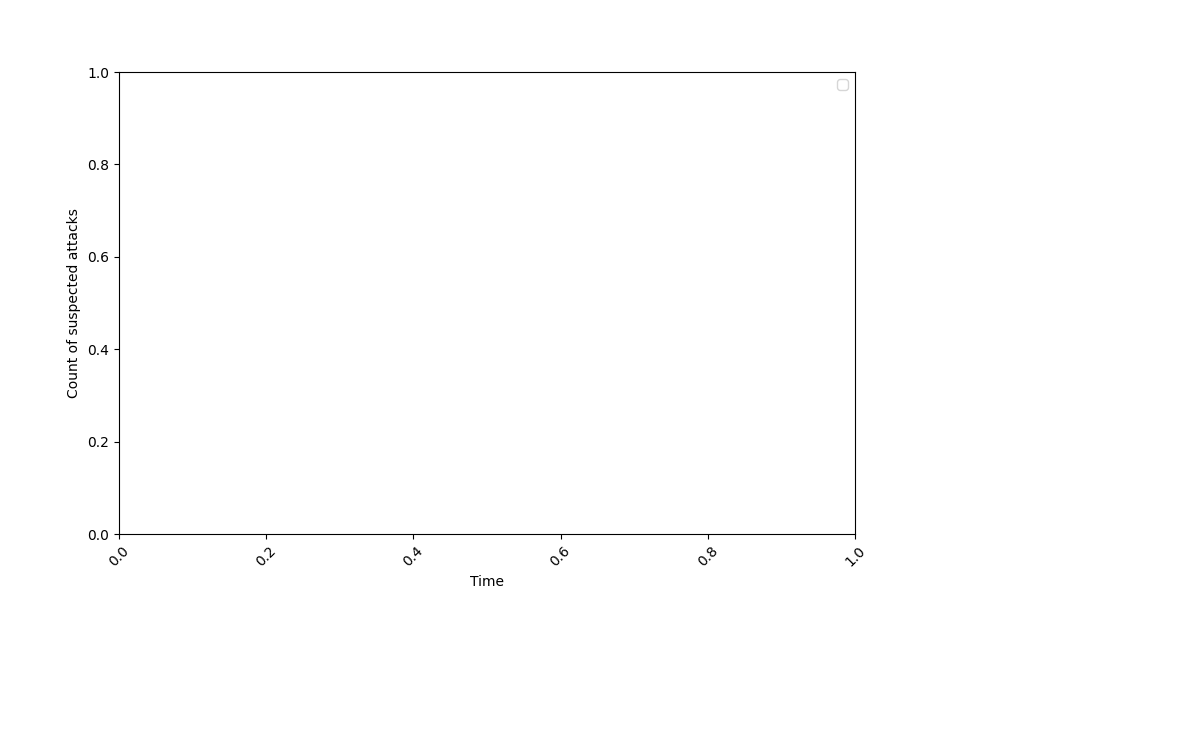

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


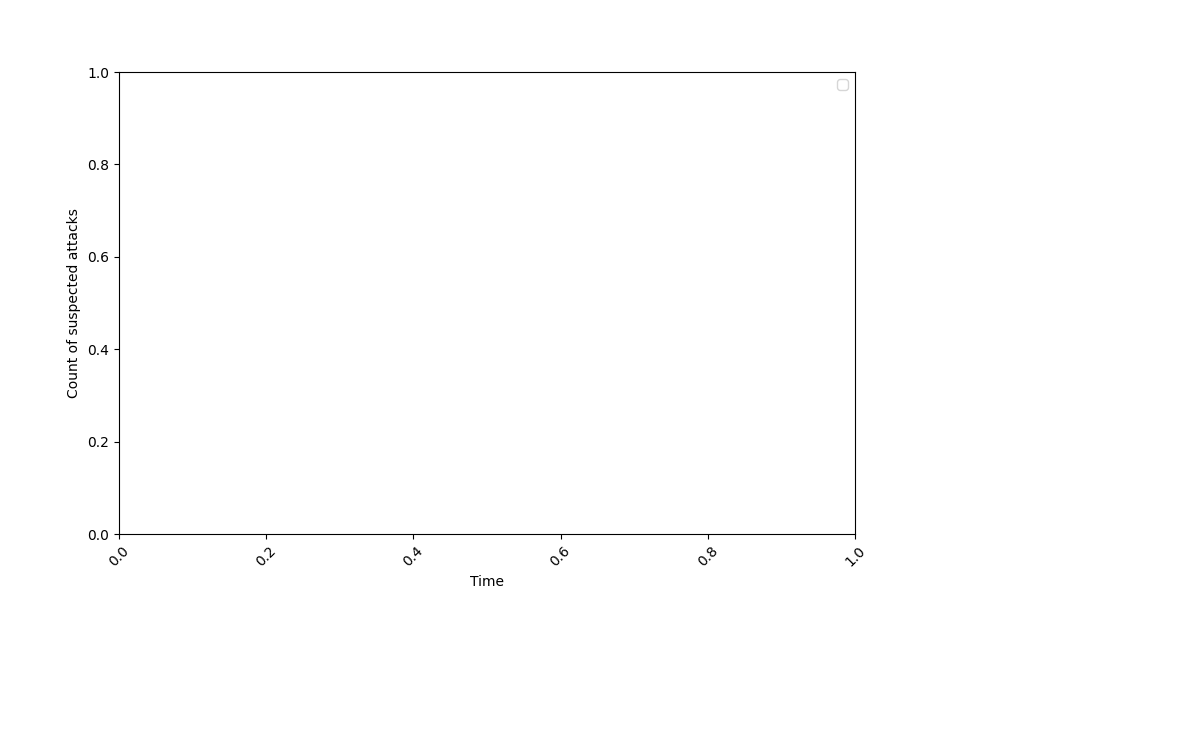

No handles with labels found to put in legend.


In [ ]:
fig_1, ax_1 = init_plots()
fig_2, ax_2 = init_plots()
suspect_process_attacks(fig_1, ax_2)
suspect_memory_attacks(fig_2, ax_2)